# PREVENDO O RISCO DE INADIMPLÊNCIA NO CRÉDITO RESIDENCIAL

### MODEL SELECTION AND TUNNING

#### Udacity - Engenheiro de Machine Learning
Vinicius Ferreira Santos - vyniciuss@gmail.com

## HOME CREDIT


### Importando as bibliotecas

In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
import sys
import pickle
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ================================================== #
#               Classifiers                          #
# ================================================== #
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
# ================================================== #
#               Validation and Test                  #
# ================================================== #
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn import cross_validation
# ===================================================#
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## CARREGANDO OS DADOS

In [8]:
#carregando os dados de treinamento
data_train = pd.read_csv("data/application_train_new.csv")

display(data_train.head(n=1))


,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,SK_ID_CURR,TARGET
0,0,-0.583687,0.783762,-0.464117,-0.098525,-0.47329,-0.055568,1.50688,0.894907,0.377004,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100002,1


**Tunning** é o processo de buscar os melhores hiperparâmetros para um determinado estimador. Para facilitar o trabalho, tal processo será executado com o auxílio do GridSearchCV que, como descrito na documentação do sklearn, realiza uma busca exaustiva sobre valores de parâmetros especificados para um estimador. Como podemos perceber, esse é um processo caro e lento de se realizar com computadores pessoais se a massa de dados for muito grande. Dessa forma, irei separar uma amostra de 16 mil linhas, onde 10 mil será para treino e 6 mil para teste, afim de facilitar o processo.


In [48]:
features = data_train.sample(n = 16000, random_state = 42)
labels = features['TARGET']
features = features.drop(columns = ['TARGET', 'SK_ID_CURR', 'Unnamed: 0'])
features.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
245895,2.548310,0.855572,-0.295497,2.214159,-0.235201,-0.905926,0.627866,0.800316,1.242524,-0.869720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98194,-0.583687,1.501855,2.042883,1.908359,2.447259,-1.163509,0.288497,0.513517,0.962833,-1.028056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36463,-0.583687,0.783762,-0.210865,1.094133,0.034632,1.519881,-0.428509,0.893393,0.704988,1.015737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
249923,-0.583687,1.501855,-0.899268,-0.078784,-0.917721,2.486791,-0.822415,0.233528,-1.784354,-0.108515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
158389,-0.583687,-0.652422,-0.746195,-0.830062,-0.885976,-0.051024,-0.983048,0.540759,-0.672487,1.656369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Separando em dados treino e teste

In [19]:
x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=6000,
                                                    random_state=42,
                                                    stratify=labels)

## Escolha e Afinamento de um Modelo

### Treinar uma variedade de classificadores

Como estou com um problema de natureza superviosionada e com classes desbalanceadas, usarei os seguintes algorítmos:

- Adaboost
- Gradient boosting

In [8]:
classifiers = ['adaboost', 'gradiend_boosting']

### Adaboost

Tempo de execução Adaboost: 2.336 s
Accuracy: 0.9194%
Score Roc: 79.307%
CV Score : Mean - 0.717786 | Std - 0.01726962 | Min - 0.6923086 | Max - 0.7465727


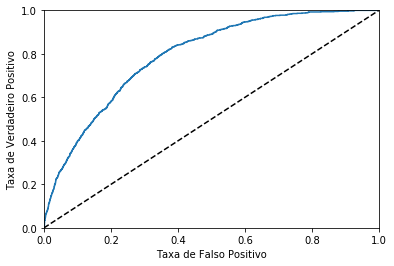

In [44]:
classifier = AdaBoostClassifier()
t0 = time()
classifier.fit(x_train, y_train)
print("Tempo de execução Adaboost:", round(time()-t0, 3), "s")
draw_roc_score(classifier, x_train, y_train)

### Gradient Boosting

Tempo de execução Gradient Boosting: 6.007 s
Accuracy: 0.9245%
Score Roc: 85.584%
CV Score : Mean - 0.7280678 | Std - 0.0085278 | Min - 0.7159346 | Max - 0.7416968


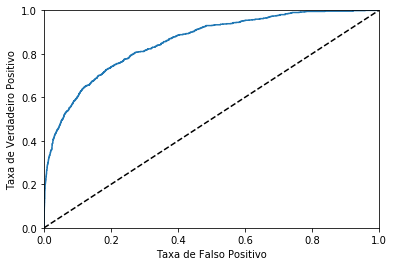

In [45]:
t0 = time()
classifier = GradientBoostingClassifier()
classifier.fit(x_train, y_train)
print("Tempo de execução Gradient Boosting:", round(time()-t0, 3), "s")
draw_roc_score(classifier, x_train, y_train)

In [42]:
def draw_roc_score(classifier, x_train, y_train):
    y_probas = classifier.predict_proba(x_train)
    y_scores = y_probas[:, 1] 
    
    predictions = classifier.predict(x_train)
    cv_score = cross_validation.cross_val_score(classifier, x_train, y_train, cv=5, scoring='roc_auc')
    print("Accuracy: {}%".format(accuracy_score(y_train, predictions)))
    print("Score Roc: {}%".format(np.round(roc_auc_score(y_train, y_scores)*100, 3)))
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #draw roc curve
    fpr1, tpr1, thresholds = roc_curve(y_train, y_scores)
    plt.plot(fpr1, tpr1, linewidth=1.5, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.show()

### Modelo Selecionado e Tuning

Como pudemos ver na seção anterior, o Gradient Boosting obteve o melhor desempenho utilizando uma instância padrão do classificador, ou seja, sem realizar qualquer ajuste nos seus hiperparâmetros. O proximo passo é identificar o melhor ajuste dos hiperparâmetros para o modelo selecionado.